In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

In [2]:
# Load Data
heart = pd.read_csv("data.csv")
heart_df = heart.copy()

In [3]:
# Split Features and Target
X = heart_df.drop(columns='target')
y = heart_df.target

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))

X_train size: (227, 13), X_test size: (76, 13)


In [4]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [5]:
import joblib
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [54]:
# -------------------------------
# 1️⃣ Hyperparameter Tuning - Logistic Regression
# -------------------------------
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

grid_lr = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train_scaler, y_train)

print("Best Parameters for Logistic Regression:", grid_lr.best_params_)
print("Best Accuracy:", round(grid_lr.best_score_ * 100, 2), "%")

Best Parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2'}
Best Accuracy: 80.14 %


In [55]:
# -------------------------------
# 2️⃣ Hyperparameter Tuning - KNN
# -------------------------------
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'metric': ['minkowski', 'euclidean', 'manhattan']
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_knn.fit(X_train_scaler, y_train)

print("Best Parameters for KNN:", grid_knn.best_params_)
print("Best Accuracy:", round(grid_knn.best_score_ * 100, 2), "%")

Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 3}
Best Accuracy: 81.92 %


In [56]:
# -------------------------------
# 3️⃣ Hyperparameter Tuning - SVM
# -------------------------------
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=5, scoring='accuracy')
grid_svc.fit(X_train_scaler, y_train)

print("Best Parameters for SVM:", grid_svc.best_params_)
print("Best Accuracy:", round(grid_svc.best_score_ * 100, 2), "%")



Best Parameters for SVM: {'C': 0.1, 'kernel': 'linear'}
Best Accuracy: 82.38 %


In [57]:
# -------------------------------
# 4️⃣ Hyperparameter Tuning - Random Forest
# -------------------------------
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 20]
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train_scaler, y_train)

print("Best Parameters for Random Forest:", grid_rf.best_params_)
print("Best Accuracy:", round(grid_rf.best_score_ * 100, 2), "%")

Best Parameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
Best Accuracy: 82.8 %


In [58]:
# -------------------------------
# 5️⃣ Hyperparameter Tuning - Decision Tree
# -------------------------------
param_grid_dt = {
    'max_depth': [None, 5, 10, 20],
    'criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train_scaler, y_train)

print("Best Parameters for Decision Tree:", grid_dt.best_params_)
print("Best Accuracy:", round(grid_dt.best_score_ * 100, 2), "%")

Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 5}
Best Accuracy: 74.05 %


In [68]:
# -------------------------------
# 6️⃣ Train Models with Best Parameters
# -------------------------------
best_models = {
    "Logistic Regression": LogisticRegression(**grid_lr.best_params_),
    "KNN": KNeighborsClassifier(**grid_knn.best_params_),
    "SVM": SVC(**grid_svc.best_params_, probability=True),
    "Random Forest": RandomForestClassifier(**grid_rf.best_params_),
    "Decision Tree": DecisionTreeClassifier(**grid_dt.best_params_)
}


In [69]:
results = {}
for name, model in best_models.items():
    model.fit(X_train_scaler, y_train)
    score = model.score(X_test_scaler, y_test)
    results[name] = score
    print(f"{name} Accuracy: {round(score * 100, 2)}%")

# Best Model Selection
best_model = max(results, key=results.get)
print(f"\n✅ Best Model: {best_model} with {round(results[best_model] * 100, 2)}% accuracy")

Logistic Regression Accuracy: 88.16%
KNN Accuracy: 84.21%
SVM Accuracy: 86.84%
Random Forest Accuracy: 85.53%
Decision Tree Accuracy: 81.58%

✅ Best Model: Logistic Regression with 88.16% accuracy


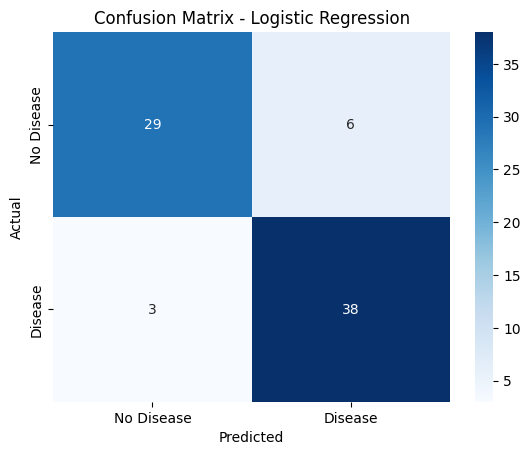

In [70]:
# -------------------------------
# 7️⃣ Confusion Matrix for Best Model
# -------------------------------
best_final_model = best_models[best_model]
y_pred_best = best_final_model.predict(X_test_scaler)

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model}")
plt.show()

In [71]:
# -------------------------------
# ✅ Ensemble Learning - Voting Classifier
# -------------------------------
ensemble_hard = VotingClassifier(
    estimators=[
        ("Logistic Regression", best_models["Logistic Regression"]),
        ("KNN", best_models["KNN"]),
        ("SVM", best_models["SVM"]),
        ("Random Forest", best_models["Random Forest"]),
        ("Decision Tree", best_models["Decision Tree"])
    ],
    voting='hard'  # Majority voting
)

In [72]:
ensemble_soft = VotingClassifier(
    estimators=[
        ("Logistic Regression", best_models["Logistic Regression"]),
        ("KNN", best_models["KNN"]),
        ("SVM", best_models["SVM"]),
        ("Random Forest", best_models["Random Forest"]),
        ("Decision Tree", best_models["Decision Tree"])
    ],
    voting='soft'  # Probability-based voting
)

In [73]:
# Train Ensemble Models
ensemble_hard.fit(X_train_scaler, y_train)
ensemble_soft.fit(X_train_scaler, y_train)

# Predictions
y_pred_hard = ensemble_hard.predict(X_test_scaler)
y_pred_soft = ensemble_soft.predict(X_test_scaler)

# Evaluate Ensemble Models
hard_acc = accuracy_score(y_test, y_pred_hard)
soft_acc = accuracy_score(y_test, y_pred_soft)

In [74]:
print(f"\n🎯 Hard Voting Accuracy: {round(hard_acc * 100, 2)}%")
print(f"🎯 Soft Voting Accuracy: {round(soft_acc * 100, 2)}%")


🎯 Hard Voting Accuracy: 88.16%
🎯 Soft Voting Accuracy: 85.53%


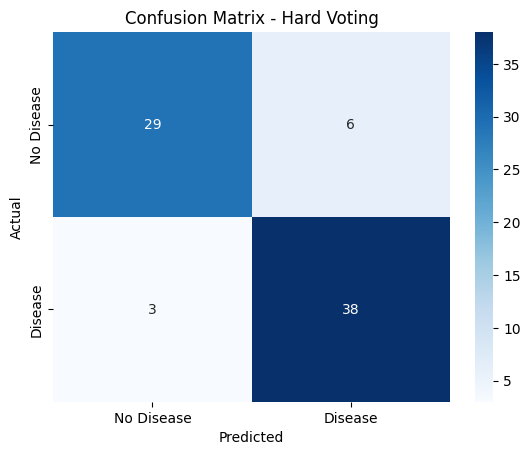


✅ Best Ensemble Model: Hard Voting
Classification Report
               precision    recall  f1-score   support

           0       0.91      0.83      0.87        35
           1       0.86      0.93      0.89        41

    accuracy                           0.88        76
   macro avg       0.88      0.88      0.88        76
weighted avg       0.88      0.88      0.88        76



In [75]:
# -------------------------------
# ✅ Confusion Matrix for Best Model
# -------------------------------
best_ensemble = "Hard Voting" if hard_acc > soft_acc else "Soft Voting"
best_preds = y_pred_hard if hard_acc > soft_acc else y_pred_soft

cm = confusion_matrix(y_test, best_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_ensemble}")
plt.show()

print("\n✅ Best Ensemble Model:", best_ensemble)
print("Classification Report\n", classification_report(y_test, best_preds))

In [83]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define Boosting Models
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lgbm = LGBMClassifier()


# Train Models
xgb.fit(X_train_scaler, y_train)
lgbm.fit(X_train_scaler, y_train)


# Predictions
y_pred_xgb = xgb.predict(X_test_scaler)
y_pred_lgbm = lgbm.predict(X_test_scaler)


# Evaluate Individual Boosting Models
print("🔹 XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("🔹 LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))



/Users/pragyanadhikari/Desktop/Heart/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [17:45:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/Users/pragyanadhikari/Desktop/Heart/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/Users/pragyanadhikari/Desktop/Heart/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [17:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/pragyanadhikari/Desktop/Heart/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

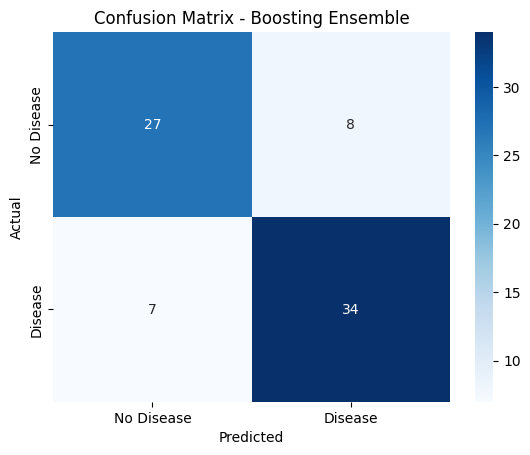

In [84]:
# Create an Ensemble with Boosting Models
ensemble_boosting = VotingClassifier(
    estimators=[
        ('XGB', xgb),
        ('LGBM', lgbm),
        
    ],
    voting='soft'  # Use probability-based voting for better results
)

# Train Ensemble
ensemble_boosting.fit(X_train_scaler, y_train)

# Predictions
y_pred_boost = ensemble_boosting.predict(X_test_scaler)

# Evaluate Ensemble Model
boost_acc = accuracy_score(y_test, y_pred_boost)
print("\n✅ Boosting Ensemble Accuracy:", boost_acc)

# Classification Report
print("\nClassification Report\n", classification_report(y_test, y_pred_boost))

# Confusion Matrix
cm_boost = confusion_matrix(y_test, y_pred_boost)
sns.heatmap(cm_boost, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Disease", "Disease"],
            yticklabels=["No Disease", "Disease"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Boosting Ensemble")
plt.show()


In [85]:
from sklearn.ensemble import StackingClassifier

In [86]:
# Step 1: Define base models
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lgbm = LGBMClassifier()

In [88]:
# Step 2: Define meta-model (Logistic Regression)
meta_model =LogisticRegression()

In [89]:
# Step 3: Create Stacked Ensemble Model
stacked_model = StackingClassifier(
    estimators=[('xgb', xgb), ('lgbm', lgbm)], 
    final_estimator=meta_model
)


/Users/pragyanadhikari/Desktop/Heart/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [17:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/pragyanadhikari/Desktop/Heart/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [17:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/Users/pragyanadhikari/Desktop/Heart/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [17:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 99, number of negative: 82
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 181, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546961 -> initscore=0.188401
[LightGBM] [Info] Start training from score 0.188401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/pragyanadhikari/Desktop/Heart/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pragyanadhikari/Desktop/Heart/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pragyanadhikari/Desktop/Heart/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pragyanadhikari/Desktop/Heart/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/pragyanadhikari/Desktop/Heart/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pragyanadhikari/Desktop/Heart/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


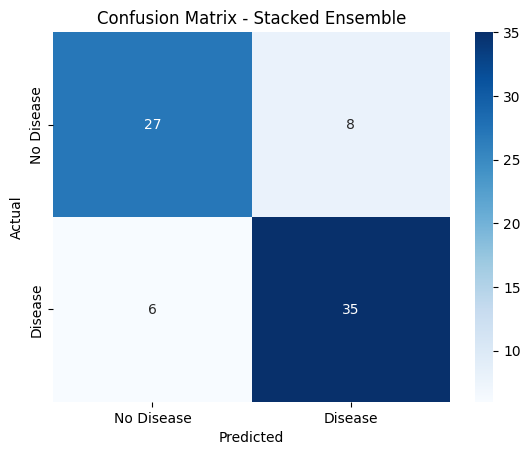

In [90]:
# Step 4: Train the stacked model
stacked_model.fit(X_train_scaler, y_train)

# Step 5: Predictions from the stacked model
y_pred_stack = stacked_model.predict(X_test_scaler)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred_stack)
print(f"Stacked Ensemble Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred_stack))

# Step 7: Confusion Matrix (Optional, but useful for better understanding)
cm = confusion_matrix(y_test, y_pred_stack)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Stacked Ensemble")
plt.show()

In [91]:
import joblib

In [92]:
joblib.dump(stacked_model, 'stacked_model.pkl')
print("Model saved to 'stacked_model.pkl'")

Model saved to 'stacked_model.pkl'
